# Project 1 - Financial Engineering

In [1]:
# Intro to Financial Engineering
# Exercises week 2

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import yfinance as yf
import datetime 
import scipy.optimize as optimize
import nelson_siegel_svensson as ns
from dateutil.relativedelta import relativedelta



from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, calibrate_nss_ols

In [145]:
#!pip install PulP
#pulptest

In [144]:
#!brew install glpk

# Reading in the data (manually)

## Data

In [2]:

########### Exercise 3 ###########
print('\n\n-----------------------------------------------------------------------')
print('Exercise 3')
print('-----------------------------------------------------------------------\n')

start_date_str = '2021-09-15'

print("Data collected manually from the website 'http://www.nasdaqomxnordic.com/bonds/denmark' on " +
		start_date_str + '\n')

start_date = datetime.datetime.fromisoformat(start_date_str)
last_coupon_date = datetime.datetime.fromisoformat('2020-11-15')

dict_bonds = {'Bond':['1,5St.l.23 GB', '3St.l. 21 GB', '4,5 St.l 39 GB', '7 St.l 24 GB',
						'DANSKE STAT 2022', 'DANSKE STAT 2029',
						'Danske Stat 2024', 'Danske Stat 2025', 'Danske Stat 2027',
						'Danske Stat 2031', 'Danske Stat 2052'],
         	 'Price':[104.32,100.61,177.96,124.3,101.12,105.99,
         	 			101.88, 109.56, 105.51, 100.57, 96.23],
         	 'Coupon':[1.50,3.00,4.50,7.00,0.25,0.50,0.00,1.75,0.50,0.00,0.25],
         	 'MatYear':[2023,2021,2039,2024,2022,2029,2024,2025,2027,2031,2052]}



-----------------------------------------------------------------------
Exercise 3
-----------------------------------------------------------------------

Data collected manually from the website 'http://www.nasdaqomxnordic.com/bonds/denmark' on 2021-09-15



In [3]:
last_coupon_date

datetime.datetime(2020, 11, 15, 0, 0)

## Calculating dirty price of the bonds and the cash flow

In [4]:
bonds = pd.DataFrame(dict_bonds)
bonds.set_index('Bond', inplace=True)

bonds['MatDate'] = bonds['MatYear'].apply(lambda x: datetime.datetime(x,11,15))
bonds['DirtyPrice'] = bonds['Price'] + bonds['Coupon']*(start_date-last_coupon_date).days/365

# Create list of times for the cash flow
times = list(range(start_date.year,max(dict_bonds['MatYear'])+1))
times = [datetime.datetime(x,11,15) for x in times]
times.insert(0,start_date)

# Create the dirty cash flow
CFdirty = pd.DataFrame(0, index=dict_bonds['Bond'], columns=times)
# Insert the dirty price
CFdirty[times[0]] = -bonds['DirtyPrice']
# Insert coupons and PAR
for i in range(1,len(times)):
	CFdirty[times[i]] = bonds['Coupon']*(times[i].year<=bonds['MatYear']) + 100*(times[i].year==bonds['MatYear'])

print('Cash flow for the bonds:\n')
print(CFdirty.transpose())

Cash flow for the bonds:

            1,5St.l.23 GB  3St.l. 21 GB  4,5 St.l 39 GB  7 St.l 24 GB  \
2021-09-15    -105.569315    -103.10863     -181.707945   -130.130137   
2021-11-15       1.500000     103.00000        4.500000      7.000000   
2022-11-15       1.500000       0.00000        4.500000      7.000000   
2023-11-15     101.500000       0.00000        4.500000      7.000000   
2024-11-15       0.000000       0.00000        4.500000    107.000000   
2025-11-15       0.000000       0.00000        4.500000      0.000000   
2026-11-15       0.000000       0.00000        4.500000      0.000000   
2027-11-15       0.000000       0.00000        4.500000      0.000000   
2028-11-15       0.000000       0.00000        4.500000      0.000000   
2029-11-15       0.000000       0.00000        4.500000      0.000000   
2030-11-15       0.000000       0.00000        4.500000      0.000000   
2031-11-15       0.000000       0.00000        4.500000      0.000000   
2032-11-15       0.000000

In [166]:
bonds.sort_values('MatDate')

,Price,Coupon,MatYear,MatDate,DirtyPrice
Bond,,,,,
3St.l. 21 GB,100.61,3.00,2021,2021-11-15,103.108630
DANSKE STAT 2022,101.12,0.25,2022,2022-11-15,101.328219
"1,5St.l.23 GB",104.32,1.50,2023,2023-11-15,105.569315
7 St.l 24 GB,124.30,7.00,2024,2024-11-15,130.130137
Danske Stat 2024,101.88,0.00,2024,2024-11-15,101.880000
Danske Stat 2025,109.56,1.75,2025,2025-11-15,111.017534
Danske Stat 2027,105.51,0.50,2027,2027-11-15,105.926438
DANSKE STAT 2029,105.99,0.50,2029,2029-11-15,106.406438
Danske Stat 2031,100.57,0.00,2031,2031-11-15,100.570000


In [163]:
YtM_sorted

,T,YtM,T_frac,NS ZC,NS FR,NSS ZC,NSS FR
3St.l. 21 GB,2021-11-15,-0.006288,0.167123,-0.005962,-0.006216,-0.006281,-0.006391
DANSKE STAT 2022,2022-11-15,-0.007022,1.167123,-0.006712,-0.006870,-0.006499,-0.006345
"1,5St.l.23 GB",2023-11-15,-0.004781,2.167123,-0.006467,-0.005296,-0.006152,-0.005039
7 St.l 24 GB,2024-11-15,-0.005788,3.169863,-0.005758,-0.003140,-0.005543,-0.003404
Danske Stat 2024,2024-11-15,-0.005859,3.169863,-0.005758,-0.003140,-0.005543,-0.003404
Danske Stat 2025,2025-11-15,-0.005133,4.169863,-0.004881,-0.001112,-0.004839,-0.001838
Danske Stat 2027,2027-11-15,-0.003811,6.169863,-0.003140,0.001836,-0.003434,0.000682
DANSKE STAT 2029,2029-11-15,-0.002257,8.172603,-0.001701,0.003442,-0.002198,0.002434
Danske Stat 2031,2031-11-15,-0.000559,10.172603,-0.000604,0.004222,-0.001160,0.003664
"4,5 St.l 39 GB",2039-11-15,0.001476,18.178082,0.001719,0.004832,0.001615,0.006171


## Calculating Yield to Maturity

In [6]:
# Get time since start
time_since_start = pd.DataFrame(np.NaN, index=times, columns=['t'])
for t in times:
	time_since_start['t'][t] = (t-start_date).days/365

# Calculate the yield to maturity
YtM = pd.DataFrame(np.NaN, index=dict_bonds['Bond'], columns=['T', 'YtM'])
YtM['T'] = bonds['MatDate']

def calculate_absdiff(r):
	value = 0
	for t in times[1:]:
		value += CFdirty[t][bond]*(1+r)**-time_since_start['t'][t]
	return abs(value+CFdirty[times[0]][bond])

for bond in dict_bonds['Bond']:
	YtM.loc[bond, 'YtM'] = optimize.newton(calculate_absdiff, -0.01, tol=1e-10, maxiter=100)

print('Yield to maturity')
print(YtM)

Yield to maturity
                          T       YtM
1,5St.l.23 GB    2023-11-15 -0.004781
3St.l. 21 GB     2021-11-15 -0.006288
4,5 St.l 39 GB   2039-11-15  0.001476
7 St.l 24 GB     2024-11-15 -0.005788
DANSKE STAT 2022 2022-11-15 -0.007022
DANSKE STAT 2029 2029-11-15 -0.002257
Danske Stat 2024 2024-11-15 -0.005859
Danske Stat 2025 2025-11-15 -0.005133
Danske Stat 2027 2027-11-15 -0.003811
Danske Stat 2031 2031-11-15 -0.000559
Danske Stat 2052 2052-11-15  0.003782


### Visualizing the yield 


Part c
Visualize yields


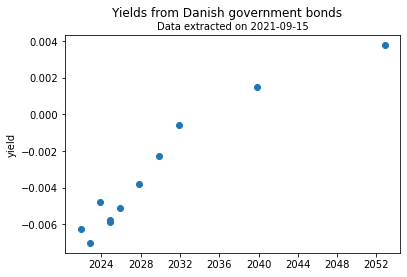

In [7]:

# Part 3
print('\nPart c')
print('Visualize yields')
# To avoid future warning deregister mpl converters
from pandas.plotting import deregister_matplotlib_converters
deregister_matplotlib_converters()

plt.scatter(YtM['T'], YtM['YtM'])
plt.suptitle('Yields from Danish government bonds')
plt.title('Data extracted on ' + start_date_str, fontsize=10)
plt.ylabel('yield')
plt.show()

# Question 1 - (yield curve) - Use the results from Exercise 2 last week



## a. Plot the yield curve. Does something look odd? If so, what?

In [158]:
YtM_sorted = YtM.sort_values('T')

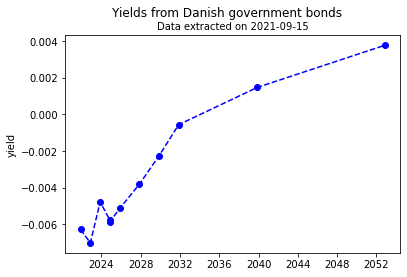

In [160]:
from pandas.plotting import deregister_matplotlib_converters
deregister_matplotlib_converters()

plt.plot(sorted(YtM_sorted['T']), YtM_sorted['YtM'], '--bo')
plt.suptitle('Yields from Danish government bonds')
plt.title('Data extracted on ' + start_date_str, fontsize=10)
plt.ylabel('yield')
plt.show()


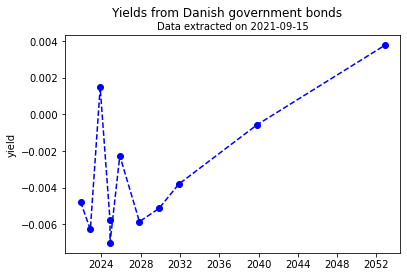

In [161]:
from pandas.plotting import deregister_matplotlib_converters
deregister_matplotlib_converters()

plt.plot(sorted(YtM['T']), YtM['YtM'], '--bo')
plt.suptitle('Yields from Danish government bonds')
plt.title('Data extracted on ' + start_date_str, fontsize=10)
plt.ylabel('yield')
plt.show()


It's interesting that the interest rates are negative but the curve is defined as a normal yield curve. A normal yield curve starts with low yields for shorter-maturity bonds and then increases for bonds with longer maturity, sloping upwards.


## b. Calculate the Nelson-Siegel coefficients and fitted interest rates

### Sorting the values from lowest YtM to highest YtM

YtM_sorted = YtM.sort_values('T')

YtM_sorted['Years'] = pd.DatetimeIndex(YtM['T']).year - 2021
YtM_sorted

### Putting the YtM and Years into an array to use for NSS calculations

In [12]:
YtM['T_frac'] = [(YtM['T'][x]-start_date).days/365 for x in range(0,len(YtM['T']))]

In [13]:
YtM

,T,YtM,T_frac
"1,5St.l.23 GB",2023-11-15,-0.004781,2.167123
3St.l. 21 GB,2021-11-15,-0.006288,0.167123
"4,5 St.l 39 GB",2039-11-15,0.001476,18.178082
7 St.l 24 GB,2024-11-15,-0.005788,3.169863
DANSKE STAT 2022,2022-11-15,-0.007022,1.167123
DANSKE STAT 2029,2029-11-15,-0.002257,8.172603
Danske Stat 2024,2024-11-15,-0.005859,3.169863
Danske Stat 2025,2025-11-15,-0.005133,4.169863
Danske Stat 2027,2027-11-15,-0.003811,6.169863
Danske Stat 2031,2031-11-15,-0.000559,10.172603


In [14]:
t_test = np.array(YtM['T_frac'])
t_test

array([ 2.16712329,  0.16712329, 18.17808219,  3.16986301,  1.16712329,
        8.17260274,  3.16986301,  4.16986301,  6.16986301, 10.17260274,
       31.1890411 ])

In [15]:
y = np.array(YtM['YtM'])
y

array([-0.00478118, -0.0062875 ,  0.00147615, -0.00578818, -0.0070222 ,
       -0.00225696, -0.00585857, -0.00513306, -0.0038109 , -0.00055858,
        0.00378196])

<function matplotlib.pyplot.show(close=None, block=None)>

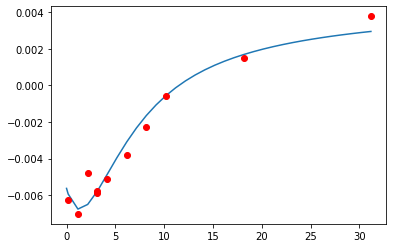

In [40]:
y = NelsonSiegelCurve(beta0=0.004709565514277782, beta1=-0.010336603480649659, beta2=-0.018173584222500427, tau=1.9241797209767895)
t=np.array(time_since_start['t'])
#t = np.linspace(0,32,32)
plt.plot(t,y(t))
plt.plot(YtM['T_frac'],YtM['YtM'],'ro')
plt.legend
plt.show

In [43]:
y(t)

array([-0.00562704, -0.00593585, -0.00675768, -0.00650389, -0.00576501,
       -0.00485886, -0.00394146, -0.00308574, -0.00231778, -0.00164702,
       -0.0010657 , -0.00056402, -0.00013   ,  0.00024436,  0.00056955,
        0.00085348,  0.0011034 ,  0.00132345,  0.00151887,  0.00169339,
        0.00185047,  0.00199179,  0.00211989,  0.00223652,  0.00234341,
        0.00244121,  0.00253125,  0.00261443,  0.0026917 ,  0.00276328,
        0.00282997,  0.00289223,  0.00295066])

In [67]:
CFdirty_new = CFdirty.transpose()

In [68]:
CFdirty_new['t'] = time_since_start
CFdirty_new['NS_ZC'] = y(t)
CFdirty_new

,"1,5St.l.23 GB",3St.l. 21 GB,"4,5 St.l 39 GB",7 St.l 24 GB,DANSKE STAT 2022,DANSKE STAT 2029,Danske Stat 2024,Danske Stat 2025,Danske Stat 2027,Danske Stat 2031,Danske Stat 2052,t,NS_ZC
2021-09-15,-105.569315,-103.10863,-181.707945,-130.130137,-101.328219,-106.406438,-101.88,-111.017534,-105.926438,-100.57,-96.438219,0.000000,-0.005627
2021-11-15,1.500000,103.00000,4.500000,7.000000,0.250000,0.500000,0.00,1.750000,0.500000,0.00,0.250000,0.167123,-0.005936
2022-11-15,1.500000,0.00000,4.500000,7.000000,100.250000,0.500000,0.00,1.750000,0.500000,0.00,0.250000,1.167123,-0.006758
2023-11-15,101.500000,0.00000,4.500000,7.000000,0.000000,0.500000,0.00,1.750000,0.500000,0.00,0.250000,2.167123,-0.006504
2024-11-15,0.000000,0.00000,4.500000,107.000000,0.000000,0.500000,100.00,1.750000,0.500000,0.00,0.250000,3.169863,-0.005765
2025-11-15,0.000000,0.00000,4.500000,0.000000,0.000000,0.500000,0.00,101.750000,0.500000,0.00,0.250000,4.169863,-0.004859
2026-11-15,0.000000,0.00000,4.500000,0.000000,0.000000,0.500000,0.00,0.000000,0.500000,0.00,0.250000,5.169863,-0.003941
2027-11-15,0.000000,0.00000,4.500000,0.000000,0.000000,0.500000,0.00,0.000000,100.500000,0.00,0.250000,6.169863,-0.003086
2028-11-15,0.000000,0.00000,4.500000,0.000000,0.000000,0.500000,0.00,0.000000,0.000000,0.00,0.250000,7.172603,-0.002318
2029-11-15,0.000000,0.00000,4.500000,0.000000,0.000000,100.500000,0.00,0.000000,0.000000,0.00,0.250000,8.172603,-0.001647


NS_ZC = NelsonSiegelCurve.zero(curve_fit1,t_test)
NS_Fwd = NelsonSiegelCurve.forward(curve_fit1,t_test)

NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve_fit,t_test)
NSS_Fwd = NelsonSiegelSvenssonCurve.forward(curve_fit,t_test)

YtM['NS ZC'] = NS_ZC
YtM['NS FR'] = NS_Fwd
YtM['NSS ZC'] = NSS_ZC
YtM['NSS FR'] = NSS_Fwd

### c. Plot the the Nelson-Siegel fitted yield curve in the same plot as before and compare
Note: You may have to remove some of the bonds from your data before computing the
Nelson-Siegel coefficients.

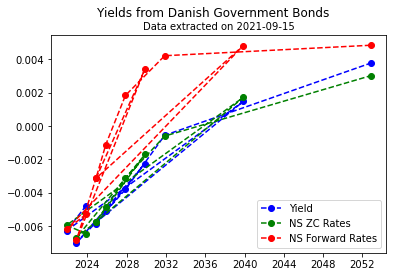

In [24]:
# Three factor NS
plt.plot(YtM['T'], YtM['YtM'], '--bo', label='Yield')
plt.plot(YtM['T'], YtM['NS ZC'],'--go', label='NS ZC Rates')
plt.plot(YtM['T'], YtM['NS FR'],'--ro', label='NS Forward Rates')
plt.legend();
plt.suptitle('Yields from Danish Government Bonds')
plt.title('Data extracted on ' + start_date_str, fontsize=10)
plt.show()

In [ ]:
# Three factor NS
plt.plot(YtM_sorted['T'], YtM_sorted['YtM'], '--bo', label='Yield')
plt.plot(YtM_sorted['T'], YtM_sorted['NS ZC'],'--go', label='NS ZC Rates')
plt.plot(YtM_sorted['T'], YtM_sorted['NS FR'],'--ro', label='NS Forward Rates')
plt.legend();
plt.suptitle('Yields from Danish Government Bonds')
plt.title('Data extracted on ' + start_date_str, fontsize=10)
plt.show()

In [ ]:
# Four factor NSS
plt.plot(YtM_sorted['T'], YtM_sorted['YtM'], '--bo', label='Yield')
plt.plot(YtM_sorted['T'], YtM_sorted['NSS ZC'],'--go', label='NSS ZC Rates')
plt.plot(YtM_sorted['T'], YtM_sorted['NSS FR'],'--ro', label='NSS Forward Rates')
plt.legend();
plt.suptitle('Yields from Danish Government Bonds')
plt.title('Data extracted on ' + start_date_str, fontsize=10)
plt.show()

# Question 2 - (duration, convexity) - Use the results from Exercise 2 last week.

## a) Compute the Macaulay duration and the modified duration for all bonds

Formula for Macaulay duration
where: \
t=respective time period \
C=periodic coupon payment \
y=periodic yield \
n=total number of periods \
M=maturity value \
Current Bond Price=present value of cash flows


#Calculate the month difference
from datetime import datetime

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

for i in range(0,len(CFdirty_new)):
    CFdirty_new['t_i'][i] = diff_month(CFdirty_new.index[i],start_date)/12

In [95]:
dict_bonds_test = {'Bond':['1,5St.l.23 GB', '3St.l. 21 GB', '4,5 St.l 39 GB', '7 St.l 24 GB',
                      'DANSKE STAT 2022', 'DANSKE STAT 2029', 
                      'Danske Stat 2024', 'Danske Stat 2025', 'Danske Stat 2027',
                      'Danske Stat 2031', 'Danske Stat 2052'],
                   'YtM':['','','','','','','','','','',''],
                   'Dirty_Price':['','','','','','','','','','',''],
                   'PV_CF':['','','','','','','','','','',''],
                   'MAC_D':['','','','','','','','','','',''],
                   'Mod_D':['','','','','','','','','','',''],
                   'Convexity':['','','','','','','','','','',''],
                   'FW_D':['','','','','','','','','','',''],
                   'Convexity_NS':['','','','','','','','','','','']
                  }


In [96]:
test = pd.DataFrame(dict_bonds_test)
test.set_index('Bond', inplace=True)
test['Dirty_Price'] = bonds['DirtyPrice']
test['YtM'] = YtM['YtM']

In [71]:
test

,YtM,Dirty_Price,PV_CF,MAC_D,Mod_D,Convexity,FW_D
Bond,,,,,,,
"1,5St.l.23 GB",-0.004781,105.569315,,,,,
3St.l. 21 GB,-0.006288,103.108630,,,,,
"4,5 St.l 39 GB",0.001476,181.707945,,,,,
7 St.l 24 GB,-0.005788,130.130137,,,,,
DANSKE STAT 2022,-0.007022,101.328219,,,,,
DANSKE STAT 2029,-0.002257,106.406438,,,,,
Danske Stat 2024,-0.005859,101.880000,,,,,
Danske Stat 2025,-0.005133,111.017534,,,,,
Danske Stat 2027,-0.003811,105.926438,,,,,


np.sum(CFdirty_test.iloc[:,0]*CFdirty_test.iloc[:,11] / (1+test['YtM'][0])**CFdirty_test.iloc[:,11])/ test['Dirty_Price'][0]

## b) Compute the convexity for all bonds

In [72]:
CFdirty_new

,"1,5St.l.23 GB",3St.l. 21 GB,"4,5 St.l 39 GB",7 St.l 24 GB,DANSKE STAT 2022,DANSKE STAT 2029,Danske Stat 2024,Danske Stat 2025,Danske Stat 2027,Danske Stat 2031,Danske Stat 2052,t,NS_ZC
2021-09-15,-105.569315,-103.10863,-181.707945,-130.130137,-101.328219,-106.406438,-101.88,-111.017534,-105.926438,-100.57,-96.438219,0.000000,-0.005627
2021-11-15,1.500000,103.00000,4.500000,7.000000,0.250000,0.500000,0.00,1.750000,0.500000,0.00,0.250000,0.167123,-0.005936
2022-11-15,1.500000,0.00000,4.500000,7.000000,100.250000,0.500000,0.00,1.750000,0.500000,0.00,0.250000,1.167123,-0.006758
2023-11-15,101.500000,0.00000,4.500000,7.000000,0.000000,0.500000,0.00,1.750000,0.500000,0.00,0.250000,2.167123,-0.006504
2024-11-15,0.000000,0.00000,4.500000,107.000000,0.000000,0.500000,100.00,1.750000,0.500000,0.00,0.250000,3.169863,-0.005765
2025-11-15,0.000000,0.00000,4.500000,0.000000,0.000000,0.500000,0.00,101.750000,0.500000,0.00,0.250000,4.169863,-0.004859
2026-11-15,0.000000,0.00000,4.500000,0.000000,0.000000,0.500000,0.00,0.000000,0.500000,0.00,0.250000,5.169863,-0.003941
2027-11-15,0.000000,0.00000,4.500000,0.000000,0.000000,0.500000,0.00,0.000000,100.500000,0.00,0.250000,6.169863,-0.003086
2028-11-15,0.000000,0.00000,4.500000,0.000000,0.000000,0.500000,0.00,0.000000,0.000000,0.00,0.250000,7.172603,-0.002318
2029-11-15,0.000000,0.00000,4.500000,0.000000,0.000000,100.500000,0.00,0.000000,0.000000,0.00,0.250000,8.172603,-0.001647


In [73]:
#test frá excel
np.sum(CFdirty_new.iloc[:,0]*CFdirty_new.iloc[:,11] / (1+test['YtM'][0])**CFdirty_new.iloc[:,11])

224.2709033668476

In [97]:
for i in range(0,len(test)):
    test['PV_CF'][i] = np.sum(CFdirty_new.iloc[:,i]*CFdirty_new.iloc[:,11] / (1+test['YtM'][i])**CFdirty_new.iloc[:,11])

<ipython-input-97-2a5380811abd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PV_CF'][i] = np.sum(CFdirty_new.iloc[:,i]*CFdirty_new.iloc[:,11] / (1+test['YtM'][i])**CFdirty_new.iloc[:,11])


In [98]:
test['MAC_D'] = test['PV_CF']/test['Dirty_Price']
test['Mod_D'] = test['MAC_D']/(1+test['YtM'])

In [100]:
for i in range(0,len(test)):
    test['Convexity'][i] = np.sum((CFdirty_new.iloc[:,11]*(CFdirty_new.iloc[:,11]+1)*CFdirty_new.iloc[:,i])/((1+test['YtM'][i])**(CFdirty_new.iloc[:,11]+2)))
    test['Convexity'][i] = test['Convexity'][i]*(1/(test['Dirty_Price'][i]))

<ipython-input-100-3dde6ca17bbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Convexity'][i] = np.sum((CFdirty_new.iloc[:,11]*(CFdirty_new.iloc[:,11]+1)*CFdirty_new.iloc[:,i])/((1+test['YtM'][i])**(CFdirty_new.iloc[:,11]+2)))
<ipython-input-100-3dde6ca17bbd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Convexity'][i] = test['Convexity'][i]*(1/(test['Dirty_Price'][i]))


In [78]:
test

,YtM,Dirty_Price,PV_CF,MAC_D,Mod_D,Convexity,FW_D
Bond,,,,,,,
"1,5St.l.23 GB",-0.004781,105.569315,224.271,2.12439,2.1346,6.77139,
3St.l. 21 GB,-0.006288,103.108630,17.2319,0.167123,0.168181,0.19753,
"4,5 St.l 39 GB",0.001476,181.707945,2539.74,13.9771,13.9565,242.931,
7 St.l 24 GB,-0.005788,130.130137,370.233,2.8451,2.86166,11.727,
DANSKE STAT 2022,-0.007022,101.328219,118.012,1.16465,1.17289,2.55935,
DANSKE STAT 2029,-0.002257,106.406438,851.502,8.00235,8.02045,73.3055,
Danske Stat 2024,-0.005859,101.880000,322.946,3.16986,3.18854,13.3741,
Danske Stat 2025,-0.005133,111.017534,445.308,4.01115,4.03184,20.7636,
Danske Stat 2027,-0.003811,105.926438,642.974,6.07,6.09322,43.6692,


## c) Compute Fisher-Weil durations and convexities using the obtained term structure model from Question 1

In [101]:
for i in range(0,len(test)):
    test['FW_D'][i] = np.sum(CFdirty_new.iloc[:,i]*CFdirty_new.iloc[:,11] / (1+CFdirty_new.iloc[:,12])**(1+CFdirty_new.iloc[:,11]))

<ipython-input-101-0deabf34204c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['FW_D'][i] = np.sum(CFdirty_new.iloc[:,i]*CFdirty_new.iloc[:,11] / (1+CFdirty_new.iloc[:,12])**(1+CFdirty_new.iloc[:,11]))


In [102]:
test['FW_D'] = test['FW_D']*(1/test['Dirty_Price'])

In [104]:
for i in range(0,len(test)):
    test['Convexity_NS'][i] = np.sum((CFdirty_new.iloc[:,i]*CFdirty_new.iloc[:,11]*(1+CFdirty_new.iloc[:,11])) / (1+CFdirty_new.iloc[:,12])**(2+CFdirty_new.iloc[:,11]))

<ipython-input-104-7c48c6108c06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Convexity_NS'][i] = np.sum((CFdirty_new.iloc[:,i]*CFdirty_new.iloc[:,11]*(1+CFdirty_new.iloc[:,11])) / (1+CFdirty_new.iloc[:,12])**(2+CFdirty_new.iloc[:,11]))


In [105]:
test['Convexity_NS'] = test['Convexity_NS']*(1/test['Dirty_Price'])

In [137]:
test

,YtM,Dirty_Price,PV_CF,MAC_D,Mod_D,Convexity,FW_D,Convexity_NS,MatDate
Bond,,,,,,,,,
"1,5St.l.23 GB",-0.004781,105.569315,224.271,2.12439,2.1346,6.77139,2.14632,6.8204,2023-11-15
3St.l. 21 GB,-0.006288,103.108630,17.2319,0.167123,0.168181,0.19753,0.168111,0.197378,2021-11-15
"4,5 St.l 39 GB",0.001476,181.707945,2539.74,13.9771,13.9565,242.931,13.9748,242.744,2039-11-15
7 St.l 24 GB,-0.005788,130.130137,370.233,2.8451,2.86166,11.727,2.86181,11.7273,2024-11-15
DANSKE STAT 2022,-0.007022,101.328219,118.012,1.16465,1.17289,2.55935,1.17221,2.55719,2022-11-15
DANSKE STAT 2029,-0.002257,106.406438,851.502,8.00235,8.02045,73.3055,7.97754,72.8635,2029-11-15
Danske Stat 2024,-0.005859,101.880000,322.946,3.16986,3.18854,13.3741,3.18729,13.3676,2024-11-15
Danske Stat 2025,-0.005133,111.017534,445.308,4.01115,4.03184,20.7636,4.02661,20.7305,2025-11-15
Danske Stat 2027,-0.003811,105.926438,642.974,6.07,6.09322,43.6692,6.0623,43.4146,2027-11-15


# Question 3 - In this task you play the role of bond portfolio manager. A client would like to invest in Danish Government bonds. He asks you to invest DKK 1.000.000 in a portfolio of bonds and wants you to assess the risk of holding this portfolio.

## d) Derive an expression for the duration of a portfolio of bonds and argue why you must use the interest rates coming from the fitted term-structure model instead of rates obtained by calculating each bond's yield to maturity.

For instance, if the yields-to-maturity on the bonds in the portfolio increase by 100 bps, the estimated drop in the portfolio value is 1.6303%.

It can be an effective measure of interest rate risk. However, its main disadvantage is that it assumes a parallel shift in the yield curve where all rates change by the same amount in the same direction. As is usually observed, interest rates change in an irregular manner, resulting in a steeper or flatter yield curve. That's the reason why we use the fitted interest rate from the model. By using the Nelson Siegel term structure we can relax on the flat interest rate assumption.

If the yield of the bond is used to calculate duration and convexity,  then the  interest  rate  curve  is   at  by  construction.   In  reality  a  non- at  term structure of interest rates are seen and the formulas above should therefore be adjusted.  For instance, the Fisher-Weil duration measures the effect of a parallel shift in the zero coupon yield curve (obtained by for instance the Nelson-Siegel model)

$$Duration_{Portfolio} =  W_1*D_1 + W_2*D_2 + ... + W_n*D_n $$


In [149]:
portfolio_duration = np.sum(test['Mod_D']*1/11)
portfolio_duration

7.422142634467656

## a) The portfolio calculations should be done using NASDAQ prices from a September-day on or after September 15th. As there is little data in this project, I would not recommend you to spend time on figuring out how to fetch data from the website automatically. Just write them down in your scripts.

### Excel

## b) Convert prices from clean to dirty or vice versa depending on your data.

### Excel

## c) The term structure of interest rates should be done with a Nelson-Siegel term structure model fitted to all relevant government bond prices.

### Excel

## e) Find a portfolio of three bonds with positive portfolio weights, such that the duration of the portfolio is X, where X = 5 + 0. 5 * (the digit sum of your student numbers).

### Excel

## f) Using these weights, calculate the convexity of the portfolio as well as the value increase/decrease, if the interest rate curve shifts up by 1% (100bp).

### Excel